## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

## <span style="color:darkred">Avaliação Final</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

Nessa avaliação será utilizado o dataset `smartphone_activity.csv` que contém 561 colunas, cujo objetivo é classificar uma entre 6 ações de uma pessoa com base em sensores disponíveis no smartphone. Vamos assumir um cenário com alta disponibilidade de exemplos não rotulados, e baixa de exemplos rotulados. Para tal, pré-treinaremos camadas de uma rede neural com dados não anotados, a qual posteriormente será usada para compor um modelo inicial de classificação.

Conforme código abaixo, use como características de entrada as 561 primeiras colunas e como classe a última coluna (activity). 

As tarefas a realizar são as seguintes:

1. **Prepare** os dados conforme o código fornecido (leia abaixo e estude o código para entender):
    * carregue o dataset e organize as features e rótulos
    * conjunto S = 2% dos dados iniciais como treinamento com rótulo (assumiremos que temos rótulos apenas para esses 2%), no formato par (x,y)
    * conjunto U = 50% dos dados iniciais como treinamento não anotado (note que S está contido em U), 
    * conjunto T = o restante dos 50% para teste, no formato par (x,y).<br><br>
    
1.  (3,0 pt) **Modelo A**: projete e treine um undercomplete autoencoder com dropout na entrada para pré-treinamento baseado em auto-supervisão. Esse autoencoder aprende a preencher os valores eliminados na camada de entrada. A arquitetura deve ter a seguinte estrutura:
    1. Encoder:
        * entrada com 561 valores
        * dropout com taxa de 0.25
        * normalização em batch
        * densa 256 neurônios, relu
        * densa 256 neurônios, relu
        * densa 64 neurônios, ativação linear 
        * normalização em batch (consideraremos essa camada como sendo o código produzido pelo encoder)
        * ativação relu
        * dropout 0.25
    2. Decoder:
        * densa 256 neurônios, ativação tanh
        * densa 256 neurônios, ativação tanh
        * densa 561 neurônios, ativação tanh
    * Usar Adam com taxa de aprendizado inicial de 0.005 e com decaimento exponencial a -0.1<br>
    * Treinar com perda MSE por 20 épocas com batch size 16 utilizando o conjunto **U**<br>
    * Exiba a perda final MSE após as 20 utilizando o conjunto **U** (use o evaluate para isso)<br>
    * Obtenha o código (saída do encoder relativa a normalização em batch após a camada de 64 dimensões) para os dados de treinamento (conjunto **U**) e armazene-o num array `code_train`. Exiba na tela esse código para a primeira instância de treinamento (índice 0)<br><br>
    
1. (3,5 pt)  **Modelo B**: rede neural profunda densa, utilizando como base o encoder do modelo A (inclusive seus pesos pré-treinados), e inserindo uma nova camada densa de classificação (em 6 classes) com ativação softmax (essa inicializada aleatoriamente). Porém **não** deve conter o primeiro dropout (logo após a camada de entrada) do encoder, ou seja a primeira camada dropout deve ser removida.<br>
    * A arquitetura deve ter portanto as seguintes camadas:
        * entrada
        * normalização em batch
        * densa 256 neurônios, relu
        * densa 256 neurônios, relu
        * densa 64 neurônios, ativação linear
        * normalização em batch
        * ativação relu
        * dropout 0.25
        * densa 6 neurônios, softmax
        
    * Utilizar Adam com taxa de aprendizado inicial de 0.001 e com decaimento em todas as épocas exponencial a -0.1
    * Treinar com perda entropia cruzada categórica por 50 épocas com batch size 16 
    * Compute como métricas, além da perda, precisão e revocação (precision / recall)<br><br>
    
1. (3,5 pt) **Avalie a rede neural de classificação** (Modelo B): 
    * Exiba o gráfico da precisão e revocação calculada no treinamento ao longo das épocas para o modelo B
    * Exiba precisão e revocação calculada no treinamento S e teste T (use evaluate no modelo B)<br><br>
    
1. **Bônus:** (+1 ponto extra) 
    * (0,5) *Análise de projeção das características*: visualize scatterplots com os 2 principais componentes obtidos do PCA com as classes dos exemplos atribuídas com cores ou marcadores diferentes. Projetar em 2D os seguintes espaços:
        1. scatterplot com projeção PCA do conjunto de S original (561 dimensões)
        1. scatterplot com projeção PCA do código (64 dimensões) do conjunto S após processado pelo "encoder" do *Modelo A* (code_train obtido no item/questão 2)
        1. scatterplot com projeção PCA do código (64 dimensões) do conjunto S após processado pelo "encoder" do *Modelo B* (treinado no item/questão 3)<br><br>    
    
    * (0,5) Obtenha um classificador SVM com kernel linear, treinado nos dados S obtendo sua representação do código (64 dimensões) da rede de classificação (modelo B). Avalie precisão e revocação no treinamento S e teste T.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import pandas as pd
df = pd.read_csv("smartphone_activity_dataset.csv")
df.shape

(10299, 562)

### Parte 1: separar dados

In [3]:
from tensorflow.keras.utils import to_categorical

rotulos = np.array(df['activity'])-1
features = np.array(df.iloc[:, :-1])

print(features.shape)
perc_train = 0.5
perc_rot = 0.02

n_train_U = int(features.shape[0]*perc_train)
n_train_S = int(features.shape[0]*perc_rot)
n_test = int(features.shape[0]*(1-perc_train))
print("Tamanho conjunto de treinamento: ", n_train_S)
print("Tamanho conjunto de treinamento não rotulado: ", n_train_U)
print("Tamanho conjunto de testes: ", n_test)

x_trainS = features[:n_train_S,:]
y_trainS = to_categorical(rotulos[:n_train_S], 6)
# rotulos discretos de treinamento
rot_trainS = rotulos[:n_train_S]

x_trainU = features[:n_train_U,:]
y_trainU = to_categorical(rotulos[:n_train_U], 6)

x_test = features[n_train_U:,:]
y_test = to_categorical(rotulos[n_train_U:], 6)
# rotulos discretos de teste
rot_test = rotulos[n_train_U:]

(10299, 561)
Tamanho conjunto de treinamento:  205
Tamanho conjunto de treinamento não rotulado:  5149
Tamanho conjunto de testes:  5149


### Parte 2: Modelo A

In [4]:
seed(1)
set_seed(2)

### instanciar modelo AE
    #encoder
entrada = keras.layers.Input(shape=(x_trainU.shape[1]))
a1 = keras.layers.Dropout(0.25)(entrada)
a2 = layers.BatchNormalization()(a1)
a3 = keras.layers.Dense(256, activation='relu')(a2)
a4 = keras.layers.Dense(256, activation='relu')(a3)
a5 = keras.layers.Dense(64, activation='linear')(a4)
a6 = layers.BatchNormalization(name='code')(a5)
a7 = keras.layers.Dense(256,activation='relu')(a6) #nao discriminou a qtd de neuronios na questao!!!!!
a8 = keras.layers.Dropout(0.25)(a7)

    #decoder
a9 = keras.layers.Dense(256, activation='tanh')(a8)
a10 = keras.layers.Dense(256, activation='tanh')(a9)
saida = keras.layers.Dense(561, activation='tanh')(a10)

autoencoder = keras.models.Model(entrada, saida)
autoencoder.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 561)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 561)               2244      
_________________________________________________________________
dense (Dense)                (None, 256)               143872    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
code (BatchNormalization)    (None, 64)                256   

In [6]:
#definando funcao que calcula decaimento exp
def scheduler(epoch, lr):
    return np.round(lr * tf.math.exp(-0.1),4)

callbacklr = tf.keras.callbacks.LearningRateScheduler(scheduler)



In [7]:
### compilar
tf.keras.backend.clear_session()
epochs = 20
batch_size=16

autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mse')

### treinar
hist = autoencoder.fit(x_trainU, x_trainU, callbacks=[callbacklr],batch_size=batch_size, epochs=epochs)


Epoch 1/20
322/322 [==============================] - 2s 4ms/step - loss: 0.0516
Epoch 2/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0390
Epoch 3/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0362
Epoch 4/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0357
Epoch 5/20
322/322 [==============================] - 1s 5ms/step - loss: 0.0334
Epoch 6/20
322/322 [==============================] - 2s 5ms/step - loss: 0.0316
Epoch 7/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0305
Epoch 8/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0295
Epoch 9/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0282
Epoch 10/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0276
Epoch 11/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0266
Epoch 12/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0257
Epoch 13/20
322/322 [====

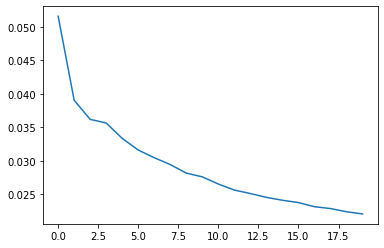

In [9]:
### avaliar MSE no treinamento
plt.plot(hist.history['loss'])

In [10]:
hist.history['loss'][-1]

0.02210036851465702

In [11]:
autoencoder.evaluate(x_trainU, x_trainU)


161/161 [==============================] - 0s 2ms/step - loss: 0.0187


0.01865185983479023

In [12]:
### obter código 64d da normalizacao em batch do treinamento
code_model = keras.models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('code').output)
code_train = np.asarray(code_model.predict(x_trainU))
### exibir código da primeira instancia do treinamento
code_train[0]

array([-0.38498712, -0.180262  ,  0.1903316 , -1.1926479 , -0.0707486 ,
       -0.41003504,  0.43647343,  0.06323438, -0.35398555, -1.1004453 ,
       -0.283273  ,  0.04105251, -1.0859079 , -0.28517735,  0.11789216,
       -0.38461876,  0.33483842, -0.5498347 , -0.5016617 ,  0.45938182,
       -0.02023453, -0.15390918,  0.5977977 , -0.70766276,  1.495714  ,
        0.20791729,  0.25104094,  0.02540439, -0.014496  , -0.11456232,
       -0.00455053,  0.2884263 ,  0.50165653, -0.36614206, -0.06144466,
       -0.05986466,  1.2352755 ,  0.10723158,  0.5563261 , -0.08825582,
        0.769439  , -0.19497278, -0.4214949 , -1.078487  , -0.28565136,
        0.01175091,  0.19854729, -0.66061985,  0.11753123,  0.15506122,
       -0.25131637, -0.67980754,  0.6757011 ,  0.18540362, -0.35830373,
       -0.6074448 ,  0.2529592 , -0.1499463 , -0.52478755, -0.515006  ,
       -0.27036262,  0.5466025 ,  0.11883853,  0.18193358], dtype=float32)

In [13]:
code_train.shape

(5149, 64)

### Parte 3: Modelo B

In [14]:
code_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 561)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 561)               2244      
_________________________________________________________________
dense (Dense)                (None, 256)               143872    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
code (BatchNormalization)    (None, 64)                256   

code_model nao contem todas as camadas solicitadas pelo model B, logo vamos olhar para o autoencoder ja pretreinado

In [18]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 561)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 561)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 561)               2244      
_________________________________________________________________
dense (Dense)                (None, 256)               143872    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
code (BatchNormalization)    (None, 64)                256   

In [17]:
autoencoder.layers

In [23]:
### criar novo modelo usando encoder pré-treinado do modelo A

# dica: obter lista de camadas
layers = [l for l in autoencoder.layers]

# montar novo modelo com nova camada de entrada
novo_modelo = keras.Sequential()
novo_modelo.add(keras.layers.Input(shape=(x_trainU.shape[1])))

# adicionar camadas anteriores usando novo_modelo.add(layers[i])
for i in range(len(layers)):
    if i not in [0,1,9,10,11]: #retirando dropout e camada de entrada
        novo_modelo.add(layers[i])



# adicionar novas camadas
novo_modelo.add(keras.layers.Dense(6, activation='softmax',name='dense_final'))


novo_modelo.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 561)               2244      
_________________________________________________________________
dense (Dense)                (None, 256)               143872    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
code (BatchNormalization)    (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)              

In [24]:
metrics = [keras.metrics.Precision(name="precision"),keras.metrics.Recall(name="recall")]

In [25]:
y_trainU.shape

(5149, 6)

In [26]:
# compilar modelo B
tf.keras.backend.clear_session()
epochs = 50
batch_size=16

novo_modelo.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy',metrics=metrics)

# treinar modelo B
hist2 = novo_modelo.fit(x_trainU, y_trainU, callbacks=[callbacklr],batch_size=batch_size, epochs=epochs,
                      validation_data=(x_test, y_test))


Epoch 1/50
322/322 [==============================] - 2s 5ms/step - loss: 0.5514 - precision: 0.8587 - recall: 0.7071 - val_loss: 0.2653 - val_precision: 0.9078 - val_recall: 0.8891
Epoch 2/50
322/322 [==============================] - 1s 4ms/step - loss: 0.2249 - precision: 0.9178 - recall: 0.9107 - val_loss: 0.1859 - val_precision: 0.9329 - val_recall: 0.9229
Epoch 3/50
322/322 [==============================] - 1s 4ms/step - loss: 0.1568 - precision: 0.9419 - recall: 0.9377 - val_loss: 0.1815 - val_precision: 0.9350 - val_recall: 0.9278
Epoch 4/50
322/322 [==============================] - 1s 4ms/step - loss: 0.1306 - precision: 0.9554 - recall: 0.9534 - val_loss: 0.1932 - val_precision: 0.9332 - val_recall: 0.9278
Epoch 5/50
322/322 [==============================] - 1s 4ms/step - loss: 0.1161 - precision: 0.9581 - recall: 0.9557 - val_loss: 0.1584 - val_precision: 0.9474 - val_recall: 0.9437
Epoch 6/50
322/322 [==============================] - 1s 3ms/step - loss: 0.0928 - precisi

Epoch 46/50
322/322 [==============================] - 1s 3ms/step - loss: 0.0236 - precision: 0.9905 - recall: 0.9905 - val_loss: 0.2016 - val_precision: 0.9481 - val_recall: 0.9464
Epoch 47/50
322/322 [==============================] - 1s 3ms/step - loss: 0.0183 - precision: 0.9949 - recall: 0.9944 - val_loss: 0.2112 - val_precision: 0.9459 - val_recall: 0.9441
Epoch 48/50
322/322 [==============================] - 1s 3ms/step - loss: 0.0247 - precision: 0.9930 - recall: 0.9928 - val_loss: 0.1782 - val_precision: 0.9529 - val_recall: 0.9515
Epoch 49/50
322/322 [==============================] - 1s 4ms/step - loss: 0.0292 - precision: 0.9903 - recall: 0.9899 - val_loss: 0.1666 - val_precision: 0.9533 - val_recall: 0.9518
Epoch 50/50
322/322 [==============================] - 1s 3ms/step - loss: 0.0170 - precision: 0.9948 - recall: 0.9944 - val_loss: 0.2120 - val_precision: 0.9460 - val_recall: 0.9427


### Parte 4: Avaliação da rede neural de classificação

In [34]:
import pandas as pd
df=pd.DataFrame(hist2.history)
df.head()

,loss,precision,recall,val_loss,val_precision,val_recall,lr
0,0.551395,0.858726,0.707128,0.265320,0.907811,0.889126,0.0009
1,0.224878,0.917792,0.910662,0.185921,0.932875,0.922913,0.0008
2,0.156839,0.941865,0.937658,0.181542,0.935029,0.927767,0.0007
3,0.130619,0.955430,0.953389,0.193233,0.933203,0.927767,0.0006
4,0.116072,0.958139,0.955720,0.158410,0.947368,0.943689,0.0005


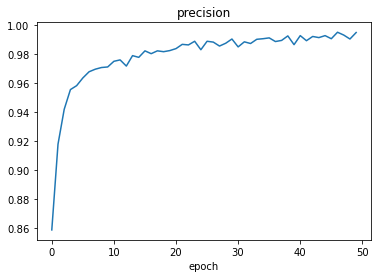

In [28]:
# exibir grafico com precision e recall das épocas
plt.plot(hist2.history["precision"])
plt.title("precision")
plt.xlabel("epoch")
plt.show()

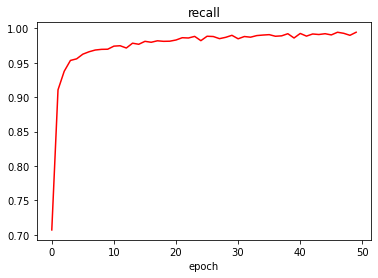

In [29]:
# exibir grafico com precision e recall das épocas
plt.plot(hist2.history["recall"],'r')
plt.title("recall")
plt.xlabel("epoch")
plt.show()

In [30]:
# avalie precision e recall final no treinamento/teste
treino = novo_modelo.evaluate(x_trainU, y_trainU, verbose=0)
teste = novo_modelo.evaluate(x_test, y_test, verbose=0)

In [31]:
print("Precisao do treino: ", treino[1])
print("Revocacao do treino: ", treino[2])
print("Precisao do teste: ", teste[1])
print("Revocacao do teste: ", teste[2])

Precisao do treino:  0.9998058080673218
Revocacao do treino:  0.9998058080673218
Precisao do teste:  0.9460249543190002
Revocacao do teste:  0.9427184462547302


### Bônus

#### 1: Análise do espaço de características aprendido (0,5 pt)

In [32]:
from sklearn.decomposition import PCA

In [ ]:
# código exemplo para scatterplot (sendo pca_train o array com dados projetados, e rot_train rotulos discretos)
scatter = ax.scatter(pca_train[:,0], pca_train[:,1], c=rot_train, cmap="jet")
legend1 = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend1)
plt.title('PCA')

#### 2: SVM no código aprendido (0,5 pt)

In [ ]:
from sklearn import svm